In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
from pathlib import Path

import earthkit.plots
import numpy as np
import xarray as xr

In [3]:
# Retrieve the data
ERA5 = xr.open_dataset(Path() / "data" / "era5-q" / "data.nc")
ERA5_Q = ERA5["q"].sel(valid_time="2024-04-02T12:00:00", pressure_level=850)

In [4]:
# Calculate the log of the specific humidity
ERA5_Q_log = np.log(ERA5_Q)
ERA5_Q_log.attrs.update(long_name="Specific humidity (ln)", units="kg kg**-1")

In [5]:
import copy


def plot_data(
    da: xr.DataArray,
    title_prefix="",
    title_postfix="",
    error=False,
    n_levels=256,
    cmap=None,
    divergence_point=None,
    levels=None,
    ticks=None,
    chart=None,
    **kwargs,
):
    UNITS = dict(t2m="degC")
    DIVERGENCE_POINT = dict(t2m=0.0)

    units = None if error else UNITS.get(da.name, None)
    divergence_point = (
        divergence_point
        if divergence_point is not None
        else 0.0
        if error
        else DIVERGENCE_POINT.get(da.name, None)
    )

    source = earthkit.plots.sources.XarraySource(da)

    # compute the default style that earthkit.maps would apply
    style = copy.deepcopy(
        earthkit.plots.styles.auto.guess_style(
            source,
            units=units or source.units,
        )
    )

    da_units = style.convert_units(da.values, source.units)

    # modify the style levels to get a smoother colourbar
    style._levels = earthkit.plots.styles.levels.Levels(
        levels
        if levels is not None
        else earthkit.plots.styles.levels.auto_range(
            da_units,
            divergence_point=divergence_point,
            n_levels=n_levels,
        )
    )
    style._legend_kwargs["ticks"] = (
        earthkit.plots.styles.levels.auto_range(
            da_units,
            divergence_point=divergence_point,
            n_levels=10,
        )
        if ticks is None
        else ticks
    )

    style._kwargs.update(kwargs)

    # force the colourmap to coolwarm for error plots
    style._colors = cmap if cmap is not None else "coolwarm" if error else style._colors

    show = chart is None
    if chart is None:
        chart = earthkit.plots.Map()

    # quickplot with the modified style
    chart.quickplot(
        da,
        units=units,
        style=style,
    )

    for m in earthkit.plots.schemas.schema.quickmap_subplot_workflow:
        if m != "title":
            getattr(chart, m)()

    for m in earthkit.plots.schemas.schema.quickmap_figure_workflow:
        getattr(chart, m)()

    chart.title(
        f"{title_prefix}{{variable_name}} on {{time:%d.%m.%Y at %H:%M}}{title_postfix}"
    )

    if show:
        chart.show()

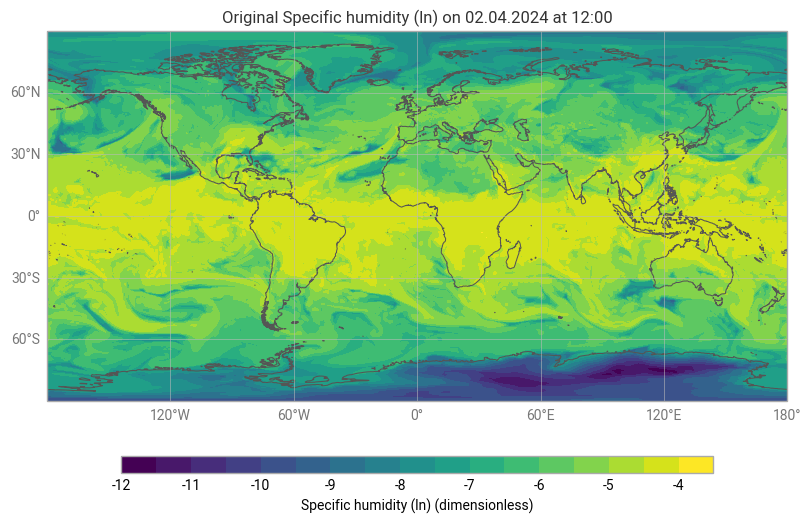

In [6]:
plot_data(
    ERA5_Q_log,
    levels=np.arange(-12, -3, 0.5),
    ticks=np.arange(-12, -3, 1),
    cmap="viridis",
    title_prefix="Original ",
)

In [7]:
from numcodecs_wasm_zfp import Zfp

In [8]:
zfp = Zfp(mode="fixed-accuracy", tolerance=0.001)

In [9]:
ERA5_Q_zfp = zfp.decode(zfp.encode(ERA5_Q.values))
ERA5_Q_zfp_log = ERA5_Q_log.copy(data=np.log(ERA5_Q_zfp))

/var/folders/8v/swxsmn0d4vz5yzwjhf6bc26x3g7lq6/T/ipykernel_19451/2675481155.py:2: RuntimeWarning: divide by zero encountered in log
  ERA5_Q_zfp_log = ERA5_Q_log.copy(data=np.log(ERA5_Q_zfp))
/var/folders/8v/swxsmn0d4vz5yzwjhf6bc26x3g7lq6/T/ipykernel_19451/2675481155.py:2: RuntimeWarning: invalid value encountered in log
  ERA5_Q_zfp_log = ERA5_Q_log.copy(data=np.log(ERA5_Q_zfp))


In [10]:
np.amax(np.abs(ERA5_Q_zfp_log - ERA5_Q_log)).item()

inf

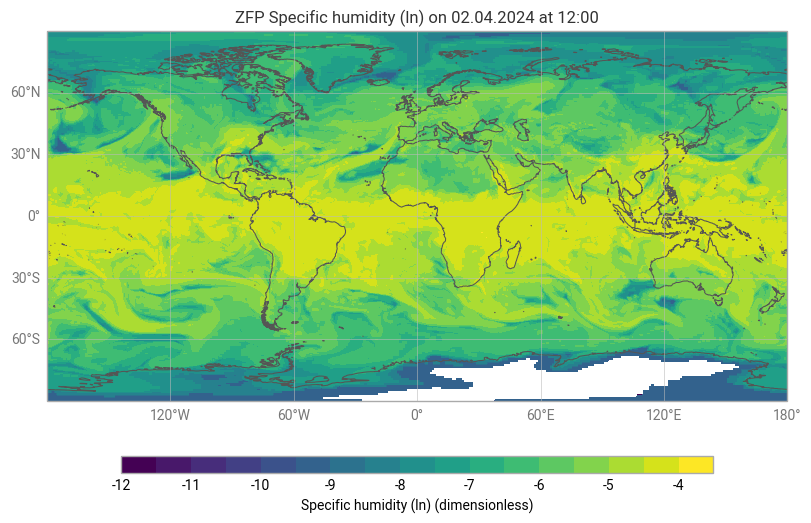

In [11]:
plot_data(
    ERA5_Q_zfp_log.copy(
        data=np.nan_to_num(ERA5_Q_zfp_log.values, nan=-100, neginf=-100, posinf=100)
    ),
    levels=np.arange(-12, -3, 0.5),
    ticks=np.arange(-12, -3, 1),
    cmap="viridis",
    title_prefix="ZFP ",
)

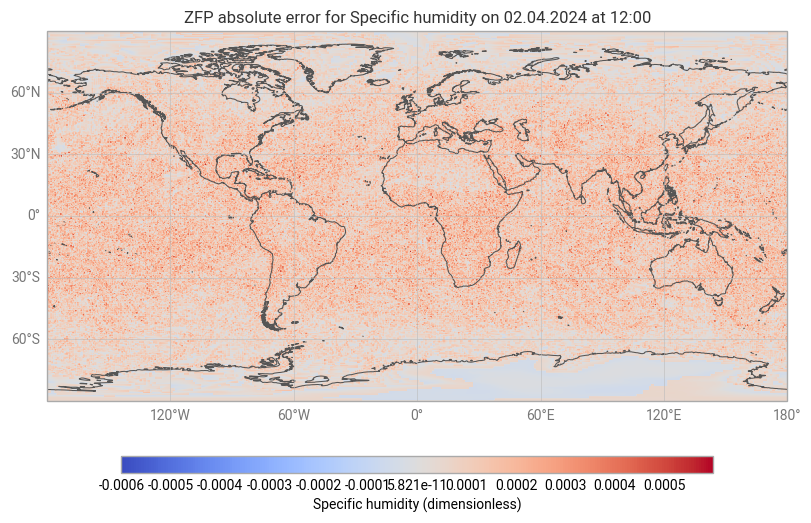

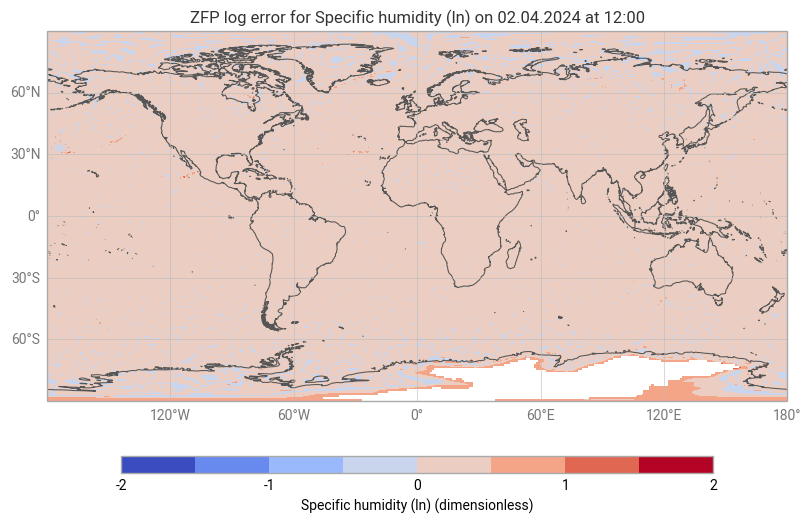

In [12]:
with xr.set_options(keep_attrs=True):
    plot_data(ERA5_Q_zfp - ERA5_Q, error=True, title_prefix="ZFP absolute error for ")
with xr.set_options(keep_attrs=True):
    plot_data(
        ERA5_Q_zfp_log - ERA5_Q_log,
        levels=np.arange(-2, 2.1, 0.5),
        ticks=np.arange(-2, 2.1, 1),
        error=True,
        title_prefix="ZFP log error for ",
    )

In [13]:
from numcodecs_safeguards import SafeguardsCodec
from numcodecs_zero import ZeroCodec

In [14]:
sg = SafeguardsCodec(
    codec=ZeroCodec(),
    safeguards=[
        dict(
            kind="qoi_eb_pw",
            qoi="ln(x)",
            type="abs",
            eb=0.25,
        )
    ],
)

In [15]:
ERA5_Q_sg = sg.decode(sg.encode(ERA5_Q.values))
ERA5_Q_sg_log = ERA5_Q_log.copy(data=np.log(ERA5_Q_sg))

In [16]:
np.amax(np.abs(ERA5_Q_sg_log - ERA5_Q_log)).item()

0.24999618530273438

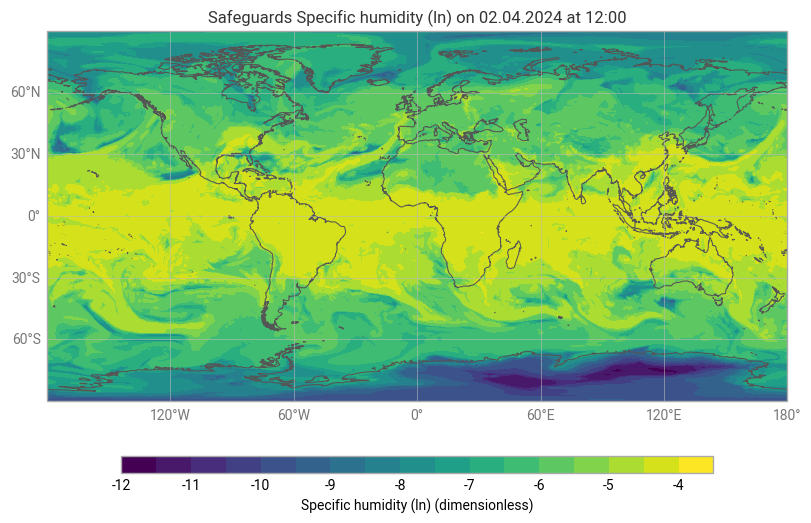

In [17]:
plot_data(
    ERA5_Q_sg_log,
    levels=np.arange(-12, -3, 0.5),
    ticks=np.arange(-12, -3, 1),
    cmap="viridis",
    title_prefix="Safeguards ",
)

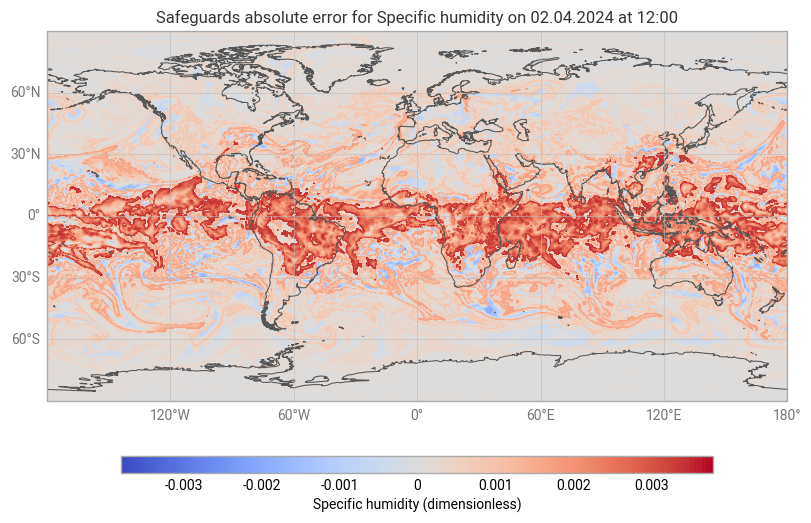

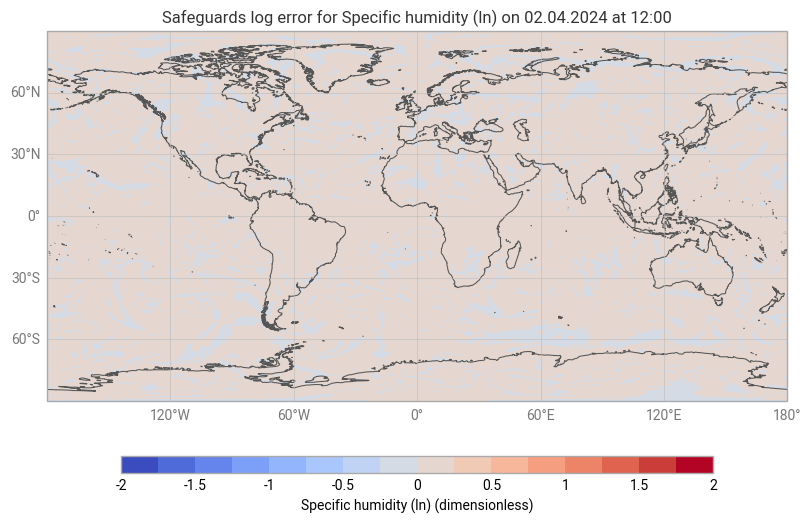

In [18]:
with xr.set_options(keep_attrs=True):
    plot_data(
        ERA5_Q_sg - ERA5_Q, error=True, title_prefix="Safeguards absolute error for "
    )
with xr.set_options(keep_attrs=True):
    plot_data(
        ERA5_Q_sg_log - ERA5_Q_log,
        levels=np.arange(-2, 2.1, 0.25),
        ticks=np.arange(-2, 2.1, 0.5),
        error=True,
        title_prefix="Safeguards log error for ",
    )